In [77]:
import yt
from yt.mods import *
import copy
import matplotlib.lines as ln
%matplotlib inline
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import numpy as np
import matplotlib.pyplot as plt
import math
from yt.utilities.physical_constants import kboltz, mp, G

In [78]:
def sound_speed(field, data):
    return np.sqrt(data[("artio", "HVAR_GAMMA")]*kboltz*data["temperature"]/mp)

yt.add_field(("gas", "sound_speed"), function=sound_speed, units="km/s")

yt : [WARNING  ] 2016-09-12 15:58:33,833 Field ('gas', 'sound_speed') already exists. To override use force_override=True.


In [79]:
pf = yt.load('AGORA_LOW_000311.art')

### projection map

yt : [INFO     ] 2016-09-12 15:58:35,496 Created 2048 chunks for ARTIO
yt : [INFO     ] 2016-09-12 15:58:38,535 Projection completed
yt : [INFO     ] 2016-09-12 15:58:38,536 xlim = 62.046875 65.953125
yt : [INFO     ] 2016-09-12 15:58:38,537 ylim = 62.046875 65.953125
yt : [INFO     ] 2016-09-12 15:58:38,540 xlim = 62.046875 65.953125
yt : [INFO     ] 2016-09-12 15:58:38,541 ylim = 62.046875 65.953125
yt : [INFO     ] 2016-09-12 15:58:38,543 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



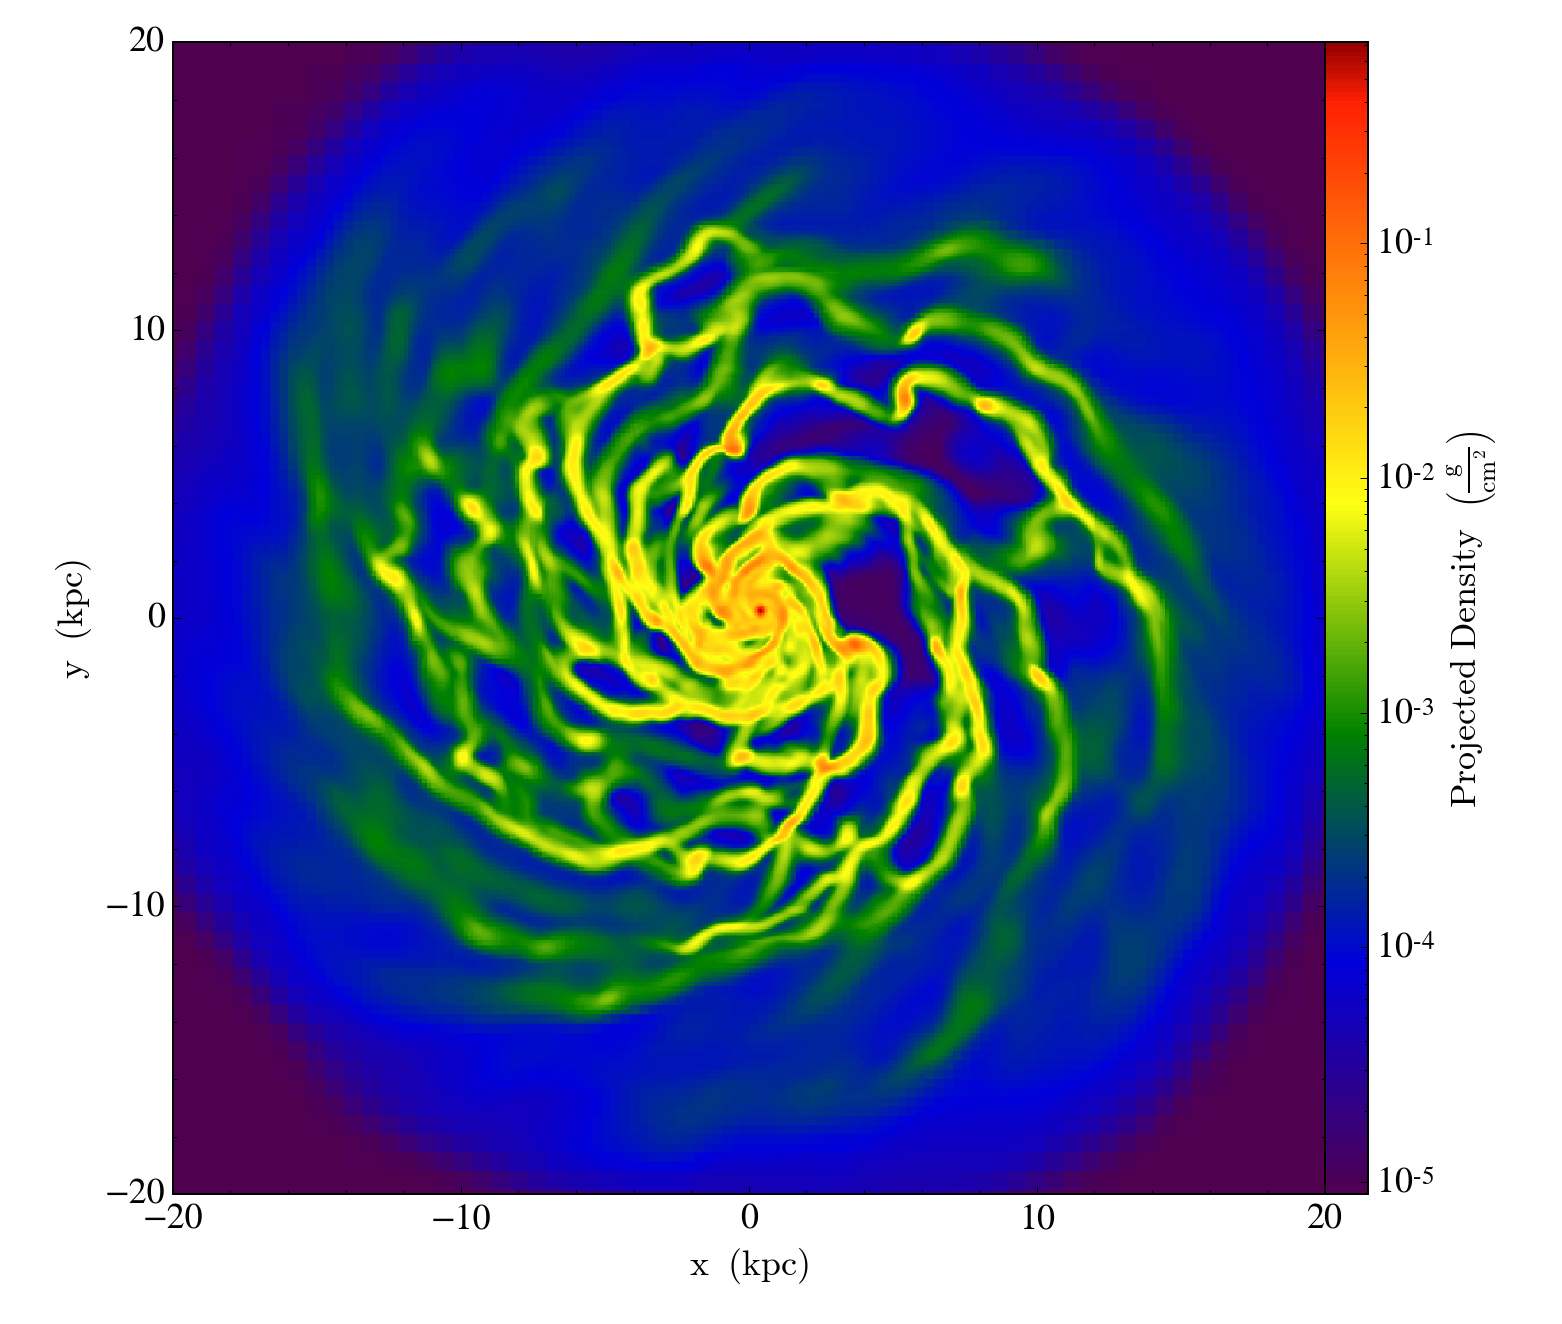

In [80]:
prj = yt.ProjectionPlot(pf, 'z', 'density', width=(40,'kpc'))
prj.show()

## find center

In [81]:
v, cen = pf.h.find_max(("gas", "density"))
sp = pf.sphere(cen, (30.0, "kpc"))
cen2 = sp.quantities.center_of_mass(use_gas=True, use_particles=False).in_units("kpc")
sp2 = pf.sphere(cen2, (1.0, "kpc"))
cen3 = sp2.quantities.max_location(("gas", "density"))
center = pf.arr([cen3[2].d, cen3[3].d, cen3[4].d], 'code_length')

yt : [INFO     ] 2016-09-12 15:58:42,083 Created 2048 chunks for ARTIO
yt : [INFO     ] 2016-09-12 15:58:45,795 Max Value is 1.83175e-21 at 64.0351562500000000 64.0273437500000000 64.0742187500000000
yt : [INFO     ] 2016-09-12 15:58:45,847 Created 52 chunks for ARTIO
yt : [INFO     ] 2016-09-12 15:58:46,629 Created 8 chunks for ARTIO


In [90]:
figure_width = 30 # kpc
sp = pf.sphere(center, (1.0*figure_width, "kpc"))
sp_dense = sp.cut_region(["obj['gas', 'density'].in_units('g/cm**3') > 1.e-25"]) # For AMR codes, consider only the cells that are dense enough

## gas rotational velocity

In [91]:
p5 = ProfilePlot(sp_dense, ("index", "cylindrical_r"),  ("gas", "cylindrical_tangential_velocity"), \
                 weight_field=("gas", "cell_mass"), n_bins=50, x_log=False)
p5.set_log("cylindrical_tangential_velocity", False)
p5.set_log("cylindrical_r", False)
p5.set_unit("cylindrical_r", 'kpc')
p5.set_xlim(1e-3, 15)
p5.set_ylim("cylindrical_tangential_velocity", -100, 350)
r_vr = p5.profiles[0].x.in_units('kpc')
vr = p5.profiles[0]["cylindrical_tangential_velocity"].in_units('km/s')

yt : [INFO     ] 2016-09-12 15:59:18,975 Created 52 chunks for ARTIO


## epicycle frequency

In [92]:
rvr = r*vr
drvdr = (rvr[1:]-rvr[:-1])/(r[1:]-r[:-1])
kappa = np.sqrt(4*(vr[1:]+vr[:-1])*drvdr/(r[1:]+r[:-1])/(r[1:]+r[:-1]))

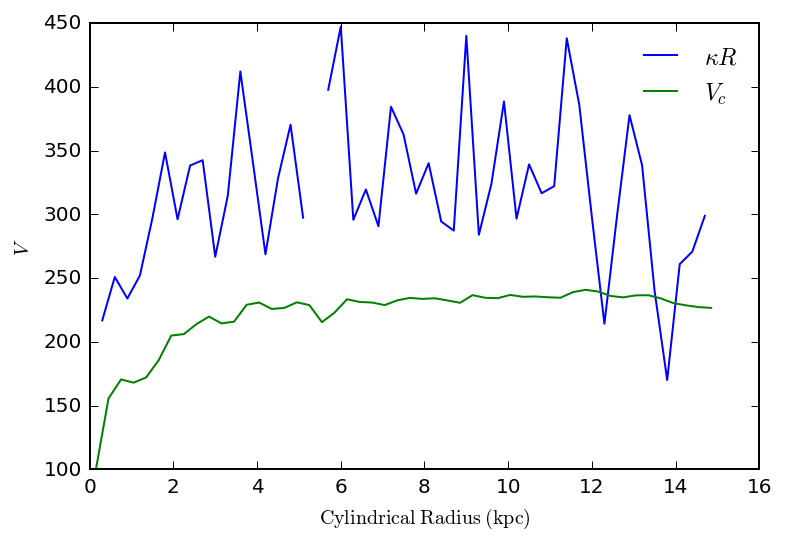

In [93]:
plt.plot((r[1:]+r[:-1])/2., (r[1:]+r[:-1])/2.*kappa, label='$\kappa R$')
plt.plot(r,vr, label='$V_c$')
plt.xlabel(r'$\rm Cylindrical \; Radius \; (kpc)$')
plt.ylabel(r'$V$')
plt.legend(frameon=False)

## mass-weighted sound speed

In [96]:
p = ProfilePlot(sp_dense, ("index", "cylindrical_r"),  ("gas", "sound_speed"), \
                 weight_field=("gas", "cell_mass"), n_bins=50, x_log=False)
p.set_log("sound_speed", False)
p.set_log("cylindrical_r", False)
p.set_unit("cylindrical_r", 'kpc')
p.set_xlim(1e-3, 15)
r_cs = p.profiles[0].x.in_units('kpc')
cs = p.profiles[0]["sound_speed"].in_units('km/s')

## gas surface density

In [100]:
p = ProfilePlot(sp_dense, ("index", "cylindrical_r"),  ("gas", "cell_mass"), weight_field=None, n_bins=50, x_log=False, accumulation=False)
p.set_log("cylindrical_r", False)
p.set_unit("cylindrical_r", 'kpc')
p.set_xlim(1e-3, 15)
r_sigma = p.profiles[0].x.in_units('kpc')
dr = (r_sigma[1:]-r_sigma[:-1]).mean()
sigma = p.profiles[0]["cell_mass"].in_units('Msun')/2/3.1416/r_sigma/dr

## Toomre q profile

In [101]:
q = kappa*cs[1:]/3.1416/sigma[1:]/G

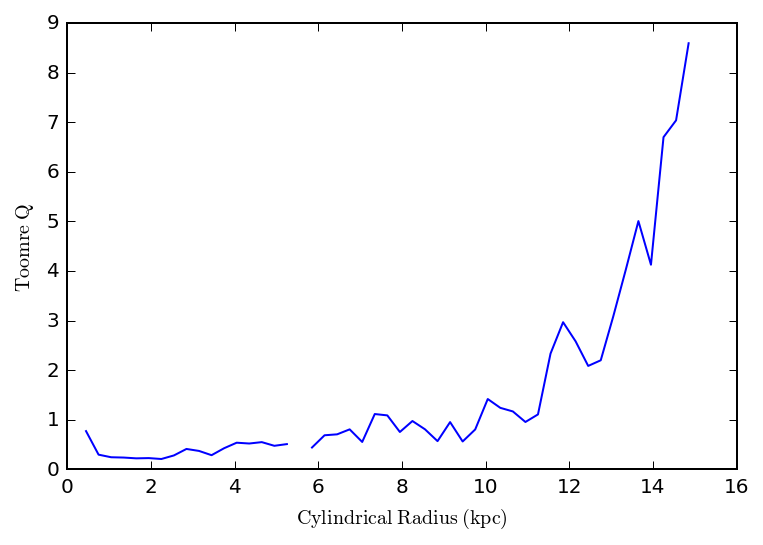

In [102]:
plt.plot(r[1:], q)
plt.xlabel(r'$\rm Cylindrical \; Radius \; (kpc)$')
plt.ylabel(r'$\rm Toomre \; Q$')